In [1]:
import h5py
import numpy as np
import healpy as hp
import os
import plotly.express as px
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from PIL import Image, ImageOps
import visualizing_funcs as vf
import calculations as calc
import loading_data as ld
import storage_management as sm
from settings import *
from constants import *

In [2]:
#File containing all data (make sure to change this to your directory)
filename=data_files_path + "/All_data_3D_temperature_17_dist_bins_nside_128.hdf5"

To calculate the emissivity in each bin, use the formula

$\Delta I_{\nu}^{\textrm{voxel}\ n,k}  = \tau_{353}^{n,k} \big ( \frac{\nu}{\nu_0} \big )^{\beta^{k}} B_{\nu}(T^{n,k}) 
= \rho_{353}^{k} \Delta E_{\textrm{B-V}}^{n,k} \big ( \frac{\nu}{\nu_0} \big )^{\beta^{k}} B_{\nu}(T^{n,k}) E_{\textrm{B-V}}^{n,k}$

where $k$ is indexing over the pixels in the sky, and $n$ is indexing over the distance bins



## Creating map of density x temperature
This part of the code contains the steps required to create a density x temperature map of the sky. It includes increasing the resolution of the temperature map, converting that to temperature emissivity and multiplying that by dEBV. 

### Create new temperature map with resolution that matches dEBV map
The temperature map has an nside of 128, but dEBV has an nside of 1024, in order to multiply these the resolution of the temperature map has to be increased. 

In [3]:
#Load all maps
data_dict=ld.load_3D_temperature_data(filename)

In [4]:
#Define  Ts, dEBV and increase resolution of Ts
n_dist_slices = data_dict['nr_of_distance_bins']

#Define dEBV and clip it due to negative values
dEBV = data_dict["dEBV"]
dEBV = np.clip(dEBV, 0, None)

##Get nside of the temperature and density maps
Ts = data_dict["temperatures"] #Original temperature map, defining for ease of use

print("Temperature resolution:", hp.get_nside(Ts[:,0]))
print("E(B-V) resolution:", hp.get_nside(dEBV[0]))

##Increase resolution of temperature map to 1024
Ts_new = calc.increase_temp_res(data_dict, 1024)
                                  
#Some checks to make sure everything is working
print("New temperature resolution:", hp.get_nside(Ts_new[0]))

print("Shape of original temperature map:", Ts.shape)
print("Shape of new temperature map:", Ts_new.shape)

print("Original temperature array:\n", Ts)
print("New temperature array:\n", Ts_new)


Temperature resolution: 128
E(B-V) resolution: 1024
New temperature resolution: 1024
Shape of original temperature map: (196608, 17)
Shape of new temperature map: (17, 12582912)
Original temperature array:
 [[18.800053  16.870003  15.337718  ...  5.        14.146356  26.819225 ]
 [18.789234  19.42068   18.598013  ... 19.548403  19.369473  16.124052 ]
 [19.040045  18.37719   22.935205  ... 18.276548   7.277836  18.685047 ]
 ...
 [26.139109  17.511135  25.047724  ... 24.625113   6.7835207 10.880443 ]
 [18.800133  18.800201  18.799892  ... 18.799957  18.799862  18.799978 ]
 [18.80004   18.79939   18.80011   ... 18.800066  18.799824  18.799965 ]]
New temperature array:
 [[18.80005264 18.80005264 18.80005264 ... 18.80003929 18.80003929
  18.80003929]
 [16.87000275 16.87000275 16.87000275 ... 18.79939079 18.79939079
  18.79939079]
 [15.33771801 15.33771801 15.33771801 ... 18.80010986 18.80010986
  18.80010986]
 ...
 [ 5.          5.          5.         ... 18.80006599 18.80006599
  18.800065

In [5]:
#Plotting temperature map with new resolution
#vf.plot_map(data_dict, Ts_new, 10, 25, 'New Temperature Map', 'K')

### Get temperature emission and frequencies
Use Wien's law for 3 given temperatures (that will correspond to each color channel) to get the maximum frequency for each. Use this with the planck function to create temperature emissivity maps at each frequency. 

In [6]:
#Calculate frequencies

freq1 = calc.WiensLaw(10) 
freq2 = calc.WiensLaw(18.8)
freq3 = calc.WiensLaw(30)

frequency = np.array([freq1, freq2, freq3]) #make array of frequencies in Hz, will be used in calculations
freq_ghz = frequency*(1e-9) #Change to GHz for printing only

freq_int = (freq_ghz).astype(int) #want to make array of integers to use in naming


print(freq_int)

[ 588 1106 1765]


To get the temperatures that correspond to the RGB channels, we use the function from calculations.py **get_temptracers_at_freq**. This function allows the user to pick between 3 methods: Gaussian, Step and Planck. I prefer Gaussian, but the user can uncomment the method they would like to do. 

Gauss and Step simply assign a range of temperatures to each color channel (with Gauss inputting the temperature into a gaussian function), but planck calculated the planck function for each frequency. All of these will return 3 new arrays that correspond to R, G and B. 

In [7]:
##Getting the RGB tracer using various methods

#Gaussian method

#Sets up gaussian function at each midpoint, calculates the fwhm so that they overlap at 0.5 and makes sure that it is "winged" (< 16K is 1 
# in Red, and >19K is 1 in Blue)

midpoints = [10, 18.8, 30] #midpoints of the frequency bands used in gaussian temperature tracers
temp_RGBtracer_maps = np.zeros((Ts_new.shape[0], len(frequency), Ts_new.shape[1])) #set up new map
sigma_G = 2 #need one std to set fwhm of gaussian

#Calculate gaussians for each distance bin
for ds_index in range(n_dist_slices):
    temp_RGBtracer_maps[ds_index] = calc.get_temptracers_at_freq(Ts_new[ds_index], method='gauss', midpoints = midpoints, sigma_G = sigma_G) #get gaussians

#get_temptracers_at_freq outputs an array of shape (3, pixel), so iterated over each distance bin it is (17, 3, pixel), but
#other functions require it to be (3, 17, pixel), so transpose it
temp_RGBtracer_maps = temp_RGBtracer_maps.transpose(1,0,2) 

#Step method
#temp_RGBtracer_maps = calc.get_temptracers_at_freq(Ts_new, method = 'step', limits=[16, 19])

#Planck
#temp_RGBtracer_maps = np.zeros((len(frequency), Ts_new.shape[0], Ts_new.shape[1])) #Create array to store the planck maps
# for i in range(len(frequency)):
#     temp_RGBtracer_maps[i] = calc.get_temptracers_at_freq(Ts_new, method='planck', nu=frequency[i] )

#Uncomment this if want to input custom method into planck method (does not make much of a difference though)
# temp_RGBtracer_map = calc.get_temptracers_at_freq(Ts_new, method = 'step', limits=[16, 19])
# for i in range(len(frequency)):
#     temp_RGBtracer_maps[i] = calc.get_temptracers_at_freq(temp_RGBtracer_map[i], method='planck', nu=frequency[i])

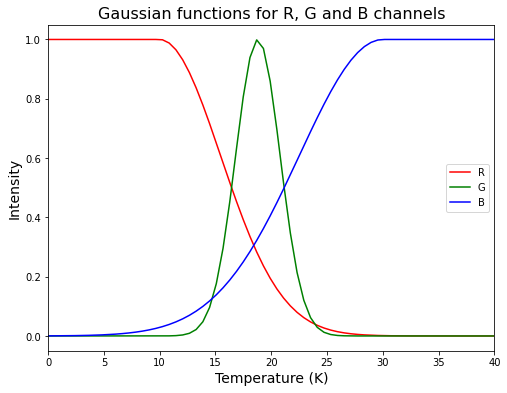

In [8]:
#Testing to see what new function looks like with test data
temp_linespace = np.linspace(0, 120, 200) #Make temperature linespace to test
gauss_arrays = calc.get_temptracers_at_freq(temp_linespace, method='gauss', midpoints = midpoints, sigma_G = sigma_G)

plt.figure(figsize=(8,6))
plt.plot(temp_linespace, gauss_arrays[0], color='red', label = 'R')
plt.plot(temp_linespace, gauss_arrays[1], color='green', label = 'G')
plt.plot(temp_linespace, gauss_arrays[2], color='blue', label = 'B')
plt.xlim(0, 40)
plt.ylabel('Intensity', fontsize=14)
plt.xlabel('Temperature (K)', fontsize=14)
plt.legend()
plt.title('Gaussian functions for R, G and B channels', fontsize=16)
plt.show()


In [9]:
#Plotting map of the temperature tracers at each frequency

# Minimum and maximums to get better visibility when plotting, 

#min_Ttracer = [0.2, 0.9, 0.2]
#max_Ttracer = None #No max since it is equal to 1
#unit_Ttracer= None #Will usually be normalized

#vf.plot_map(data_dict, temp_RGBtracer_maps[0], min_Ttracer[0], max_Ttracer, f'Temperature Tracer for {freq_int[0]} GHz', unit_Ttracer)
#vf.plot_map(data_dict, temp_RGBtracer_maps[1], min_Ttracer[1], max_Ttracer, f'Temperature Tracer for {freq_int[1]} GHz', unit_Ttracer)
#vf.plot_map(data_dict, temp_RGBtracer_maps[2], min_Ttracer[2], max_Ttracer, f'Temperature Tracer for {freq_int[2]} GHz', unit_Ttracer)

### Multiply dEBV and Temperature Tracer Maps
In order to analyze the temperature where the dust density is, dEBV and Ts_new are multiplied by multiply_dEBVandTtracer that just does a simple array multiplication at each distance slice and frequency. 

This is then normalized in normalize_multiplied_array by dividing the new dens_temp map by the maximum across the sky of all the frequencies. 

In [10]:
dens_temp = calc.multiply_dEBVandTtracer(data_dict, dEBV, temp_RGBtracer_maps, frequency)
dens_temp_norm = calc.normalize_multiplied_array(data_dict, dens_temp, frequency)

In [11]:
#Plotting density times temperature maps

#Minimum and maximums to get better visibility when plotting dens_temp
#min_dxT = None #0 #all have the same minimum
#max_dxT = None #[1, 1.5, 1] #values I used when just get_temptracers_at_freq was used, decided to comment them out to avoid weird images
#unit_dxT = None 

#vf.plot_map(data_dict, dens_temp[0], min_dxT, max_dxT, f"Temperature Tracer and $E(B-V)$ for {freq_int[0]} GHz", unit_dxT)
#vf.plot_map(data_dict, dens_temp[1], min_dxT, max_dxT, f"Temperature Tracer and $E(B-V)$ for {freq_int[1]} GHz", unit_dxT)
#vf.plot_map(data_dict, dens_temp[2], min_dxT, max_dxT[2], f"Temperature Tracer and $E(B-V)$ for {freq_int[2]} GHz", unit_dxT)



In [12]:
#Plotting normalized dens_temp

#vf.plot_map(data_dict, dens_temp_norm[0], 0, 0.4, f"Normalized Temperature Tracer and $E(B-V)$ for {freq_int[0]} GHz", None)
#vf.plot_map(data_dict, dens_temp_norm[1], 0, 0.5, f"Normalized Temperature Tracer and $E(B-V)$ for {freq_int[1]} GHz", None)
#vf.plot_map(data_dict, dens_temp_norm[2], 0, 0.4, f"Normalized Temperature Tracer and $E(B-V)$ for {freq_int[2]} GHz", None)

In [13]:
#Calculate difference of dEBV and new map with temperature
dEBV_diff = {}

for f_index in range(3):
    dEBV_diff[f_index] = np.zeros((data_dict['nr_of_distance_bins'], len(temp_RGBtracer_maps[0, 0])))
    for ds_index in range(data_dict['nr_of_distance_bins']):
        dEBV_diff[f_index, ds_index] = dens_temp_norm[f_index, ds_index] - dEBV[ds_index]

# for ds_index in range(model_nslices):
#     hp.mollview(dEBV_diff[0, ds_index], title=r"Temperature Tracer and $E(B-V)$ for 588 GHz at distance slice 0",nest=True, min = -1, max = 1, unit=r'$\mathrm{W/M^{2}\cdot sr \cdot Hz}$')

## Create RGB Images
This code creates RGB images of Cepheus, Orion A & B and the whole sky. It also creates panels to see all the plots made. 

get_RGB is used to convert the temperature into color depth. It does so by multiplying dens_temp_norm by 255 (the maximum pixel depth) and converting it into uint8. They are then brightened by brighten_image which multiplied the RGB arrays by some factor, and then clips them. 

In [14]:
#Set up global RGB arrays that will be used in other cells
R, G, B = calc.get_RGB(dens_temp_norm)

brightness_factor = 5
R, G, B = vf.brighten_image(R, brightness_factor), vf.brighten_image(G, brightness_factor), vf.brighten_image(B, brightness_factor)

### Looking at the Cepheus Local Molecular Cloud

In [15]:
#Pick section of LMC Cepheus

#Parameters that would be used in hp.gnomview
x_ceph = 2000 #x and y size of gnomview plot
y_ceph = 2000
min_ceph = 0 #no minimum
max_ceph = None #max that produces best contrast

#for fs_index in range(len(frequency)):
#    vf.plot_map_region(dens_temp_norm[fs_index, d_ceph], l_ceph, b_ceph, x_ceph, y_ceph, min_ceph, max_ceph, f"Normalized Temperature Tracer and $E(B-V)$ of the Cepheus Molecular Cloud at {freq_int[fs_index]} GHz", None)

In [16]:
#Make a path to store all images related to Cepheus

cepheus_path = sm.join_path(image_path, "Cepheus") 

#Get RGB arrays and image for Cepheus, scaled means image is brightened further
R_ceph, G_ceph, B_ceph, RGB_ceph = vf.get_region_image(R, G, B, d_ceph, l_ceph, b_ceph, x_ceph, y_ceph, scale=True)
RGB_ceph.save(cepheus_path + "/ceph_rgb_scaled.png")

Directory  /fs/lustre/cita/molinaca/Images/Cepheus  already exists.


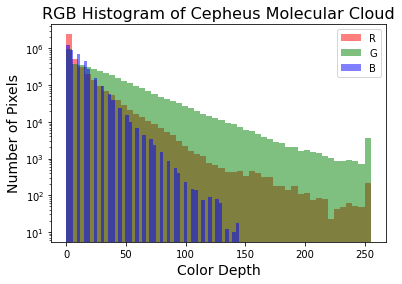

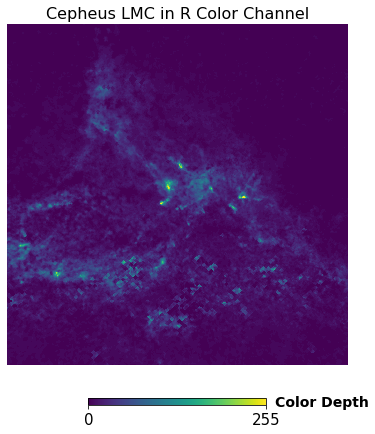

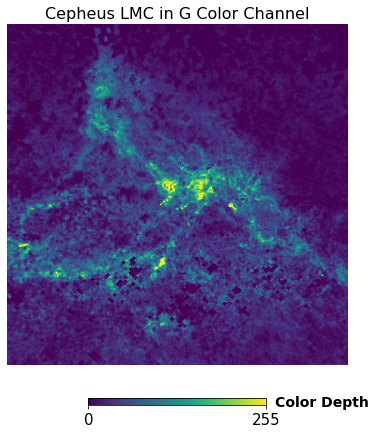

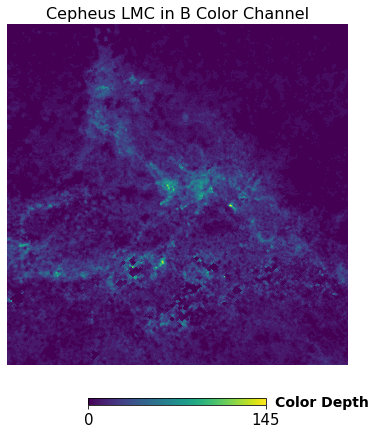

In [17]:
#Looking at histogram and gnomview of color depth of each channel

#Plotting the histograms of flattened RGB arrays
RGB_unit = 'Color Depth'
ceph_hist_title = "RGB Histogram of Cepheus Molecular Cloud"
ceph_hist_file = cepheus_path + "/ceph_rgb_hist_scaled.png"
vf.plot_RGB_histogram(R_ceph, G_ceph, B_ceph, ceph_hist_title, ceph_hist_file)

#Plotting the color depth of each channel but with gnomview

#Assign title names for plots
ceph_R_title = "Cepheus LMC in R Color Channel"
ceph_G_title = "Cepheus LMC in G Color Channel"
ceph_B_title = "Cepheus LMC in B Color Channel"

#Plotting an hp.gnomview plot of Cepheus at each color channel and saves the image
vf.plot_map_region(R, d_ceph, l_ceph, b_ceph, x_ceph, y_ceph, min_ceph, max_ceph, ceph_R_title, RGB_unit)
plt.savefig(cepheus_path + "/ceph_R.png")
vf.plot_map_region(G, d_ceph, l_ceph, b_ceph, x_ceph, y_ceph, min_ceph, max_ceph, ceph_G_title, RGB_unit)
plt.savefig(cepheus_path + "/ceph_G.png")
vf.plot_map_region(B, d_ceph, l_ceph, b_ceph, x_ceph, y_ceph, min_ceph, max_ceph, ceph_B_title, RGB_unit)
plt.savefig(cepheus_path + "/ceph_B.png")


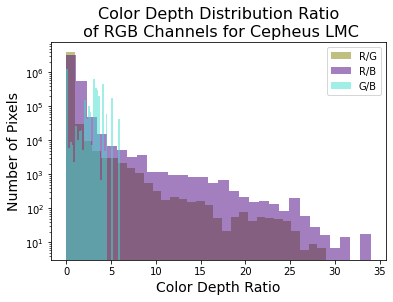

In [18]:
#Get ratio between color channels to see if it makes sense, note that currently having some issues with this function

ceph_ratio_title = "Color Depth Distribution Ratio" + "\n" + " of RGB Channels for Cepheus LMC"
ceph_ratio_file = cepheus_path + "/ceph_rgb_hist_ratios.png"
ceph_ratio_RG, ceph_ratio_RB, ceph_ratio_GB = calc.get_rgb_ratios(R_ceph, G_ceph, B_ceph, ceph_ratio_title, ceph_ratio_file)

To make it easier to visualize the steps taken to make the RGB image, a panel is made that shows all of them. This includes the old and new temperature maps, dEBV, the temperature tracer maps at each frequency, the multiplied array at each frequency, the histograms and the final RGB image. 

The function to do this is create_panel which creates the plots that have not already been made and saves them. Then it creates a subplot figure and inputs the image into each position. 

In [19]:
#Make dictionary that encompasses all maps to make it easier to make panels

maps_dict = {
    'Temp_og' : Ts,
    'Temp_new' : Ts_new,
    'Density' : dEBV,
    'Temperature Tracer' : temp_RGBtracer_maps,
    'Normalized_denstemp' : dens_temp_norm
}


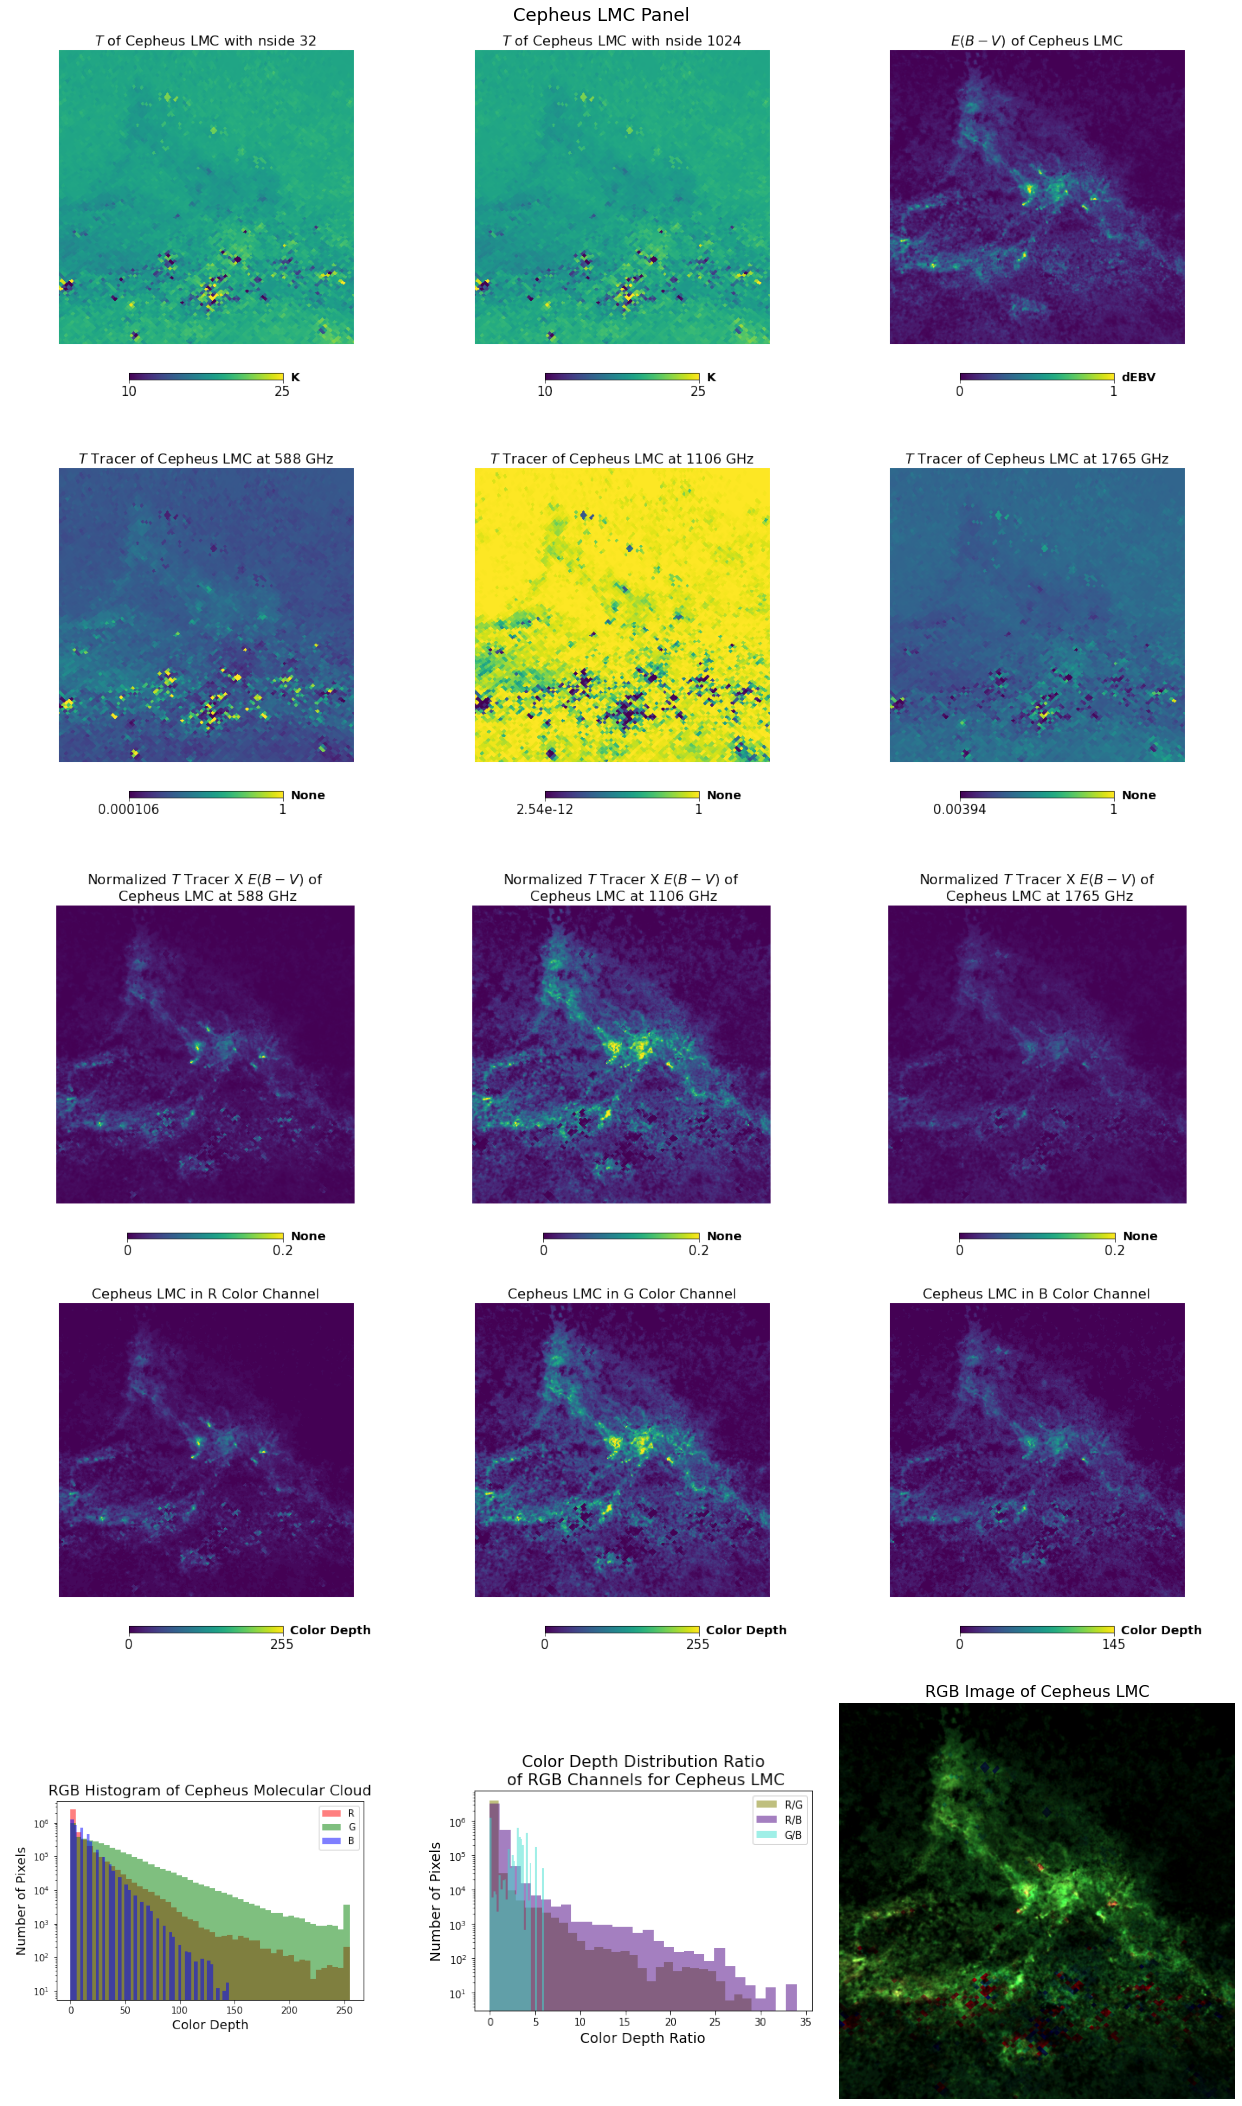

In [20]:
#Plot panel
ceph_panel_title = "Cepheus LMC"
ceph_panel_path = cepheus_path + "/ceph_"
vf.create_rgb_panel(maps_dict, freq_int, d_ceph, l_ceph, b_ceph, ceph_panel_title ,ceph_panel_path )

### Looking at Orion A and B Molecular Clouds

Now the same process followed for Cepheus will be done on the Orion A and B clouds as well as the Orion Ring

In [23]:
#Just looking at what Orion A and B look like with density x temperature map at diff frequencies

#Parameters that would be used in hp.gnomview
x_orion = 2000
y_orion = 2000
min_orion = 0
max_orion = None #max that produces best contrast

#Plotting to see what it looks like at each frequency
#for fs_index in range(len(frequency)):
#    vf.plot_map_region(dens_temp_norm[fs_index], d_orionB, l_orionB, b_orionB, x_orion, y_orion, min_orion, max_orion, f'Normalized $B$ and $E(B-V)$ of Orion B at {int(freq_ghz[fs_index])} GHz', None)

In [22]:
#Make new path to store images from Orion
orion_path = sm.join_path(image_path, "Orion")

#Get image and save
R_orion, G_orion, B_orion, RGB_orion = vf.get_region_image(R, G, B, d_orion, l_orionB, b_orionB, x_orion, y_orion, scale=True)
    #Note: I use the l and b of Orion B for the whole Orion Nebula since it is more centred
RGB_orion.save(orion_path + "/orion_rgb_scaled.png")

Directory  /fs/lustre/cita/molinaca/Images/Orion  already exists.


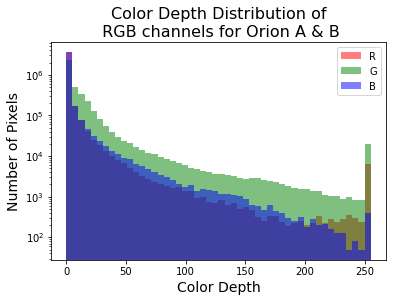

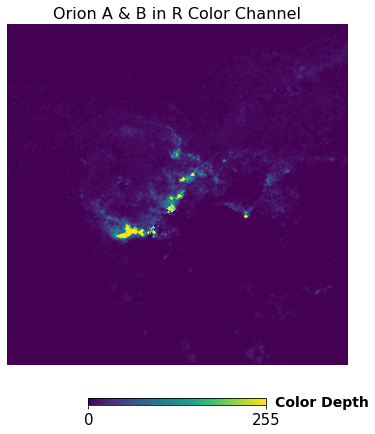

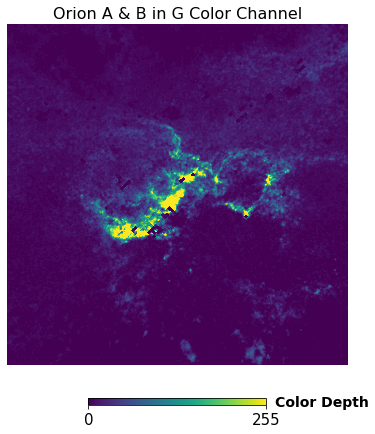

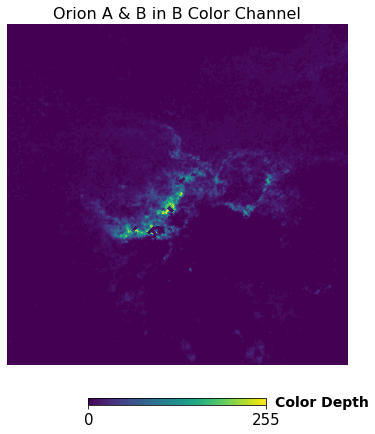

In [31]:
#Plot histograms and gnomview for each color channel 
orion_rgb_hist_title = "Color Depth Distribution of" + "\n" + " RGB channels for Orion A & B"
orion_rgb_hist_file = orion_path + "/orion_rgb_hist_scaled.png"
vf.plot_RGB_histogram(R_orion, G_orion, B_orion, orion_rgb_hist_title, orion_rgb_hist_file )

#Assign title names to plots for gnomview
orion_R_title = "Orion A & B in R Color Channel"
orion_G_title = "Orion A & B in G Color Channel"
orion_B_title = "Orion A & B in B Color Channel"

#Plotting an hp.gnomview plot of Orion at each color channel and saves the image
vf.plot_map_region(R, d_orion, l_orionB, b_orionB, x_orion, y_orion, min_orion, max_orion, orion_R_title, RGB_unit)
plt.savefig(orion_path + "/orion_R.png")
vf.plot_map_region(G, d_orion, l_orionB, b_orionB, x_orion, y_orion, min_orion, max_orion, orion_G_title, RGB_unit)
plt.savefig(orion_path + "/orion_G.png")
vf.plot_map_region(B, d_orion, l_orionB, b_orionB, x_orion, y_orion, min_orion, max_orion, orion_B_title, RGB_unit)
plt.savefig(orion_path + "/orion_B.png")

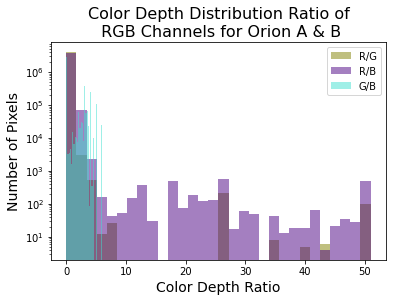

In [32]:
#Calculate ratios
orion_ratio_title = "Color Depth Distribution Ratio of" + "\n" + " RGB Channels for Orion A & B"
orion_ratio_file = orion_path + "/orion_rgb_hist_ratios.png"
orion_ratio_RG, orion_ratio_RB, orion_ratio_GB = calc.get_rgb_ratios(R_orion, G_orion, B_orion, orion_ratio_title, orion_ratio_file)

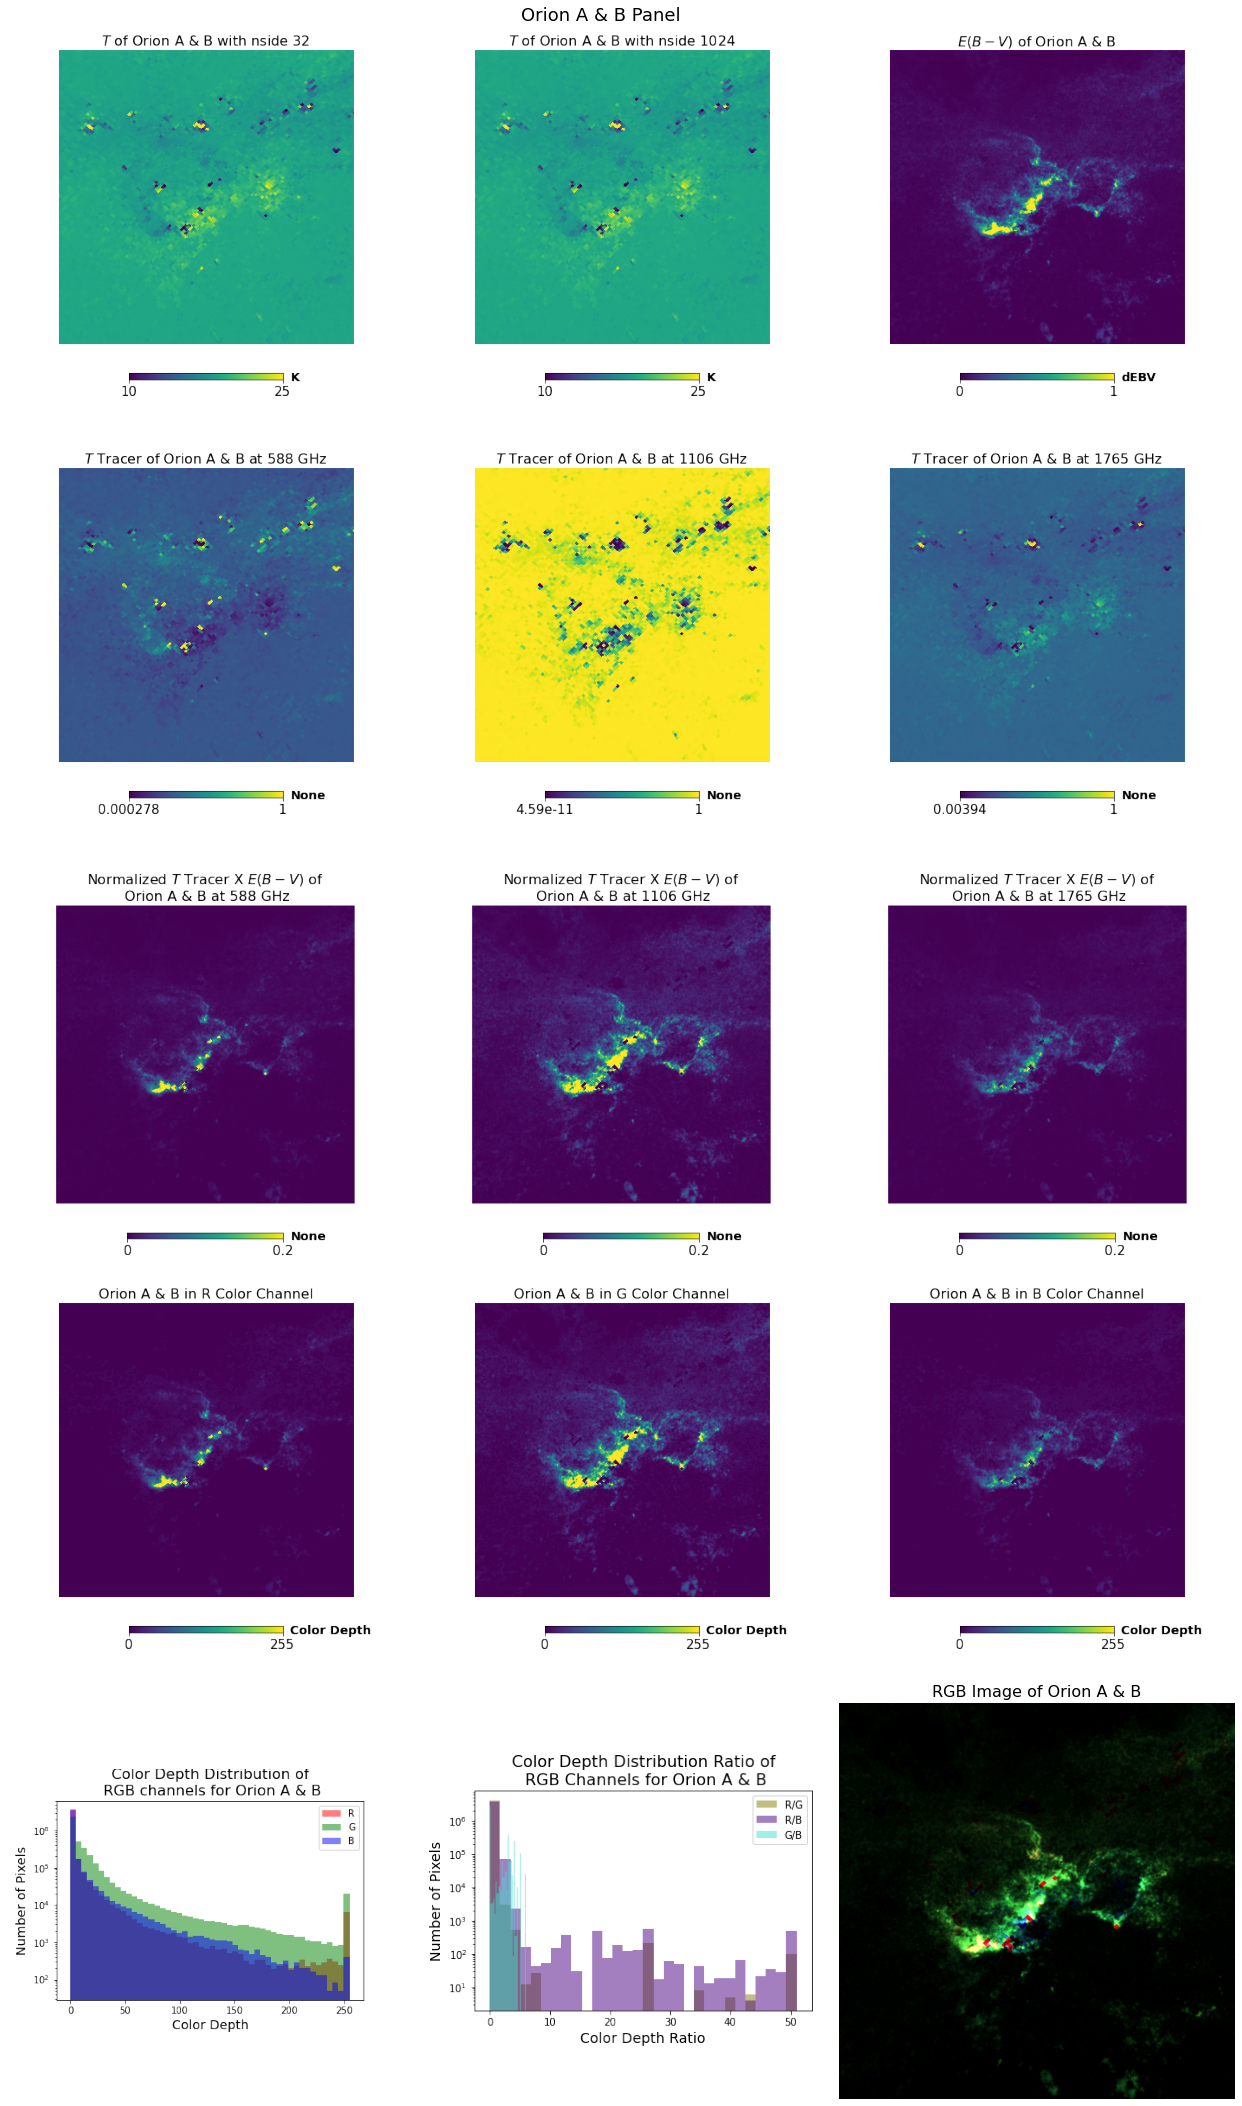

In [33]:
#Make panel with all important images
orion_panel_title = "Orion A & B"
orion_panel_path = orion_path + "/orion_"
vf.create_rgb_panel(maps_dict, freq_int, d_orion, l_orionB, b_orionB, orion_panel_title, orion_panel_path)

### Creating RGB Image of Whole Sky

In [34]:
#Get image of the "whole sky" at each distance slice
vf.get_sky_image(data_dict, R, G, B, scale=True)

In [35]:
#Make new path
allsky_path = sm.join_path(image_path, "All_sky")

#for ds_index in range(data_dict["nr_of_distance_bins"]):
    #vf.plot_RGB_histogram(R[ds_index], G[ds_index], B[ds_index], f"Color Channel Distributions of Whole sky at Distance Slice {ds_index}", allsky_path + f"/allsky_rgb_hist_{ds_index}.png")

Directory  /fs/lustre/cita/molinaca/Images/All_sky  created.


In [32]:
#Making hp.mollview plots of each color channel for the whole sky
#vf.plot_map(data_dict, R, 0, 255, f"R Channel at Distance Slice {ds_index}", r'Color Depth')
#vf.plot_map(data_dict, G, 0, 255, f"G Channel at Distance Slice {ds_index}", r'Color Depth')
#vf.plot_map(data_dict, B, 0, 255, f"B Channel at Distance Slice {ds_index}", r'Color Depth')

In [33]:
#plot_3D_temperature_slice_maps(data_dict)

## Comparing 2D Images to 3D Images
Comparing RGB from my image of Orion to a RGB values from screenshot from 3D image on youtube. This way I can scale my color channels to get the same contrast. 

This is more of a "playground" right now, has a lot of testing and not necessary to obtain images

In [51]:
#Get RGB colors for screenshot
dustmap_orion= Image.open("dustmap_cropped.png")

dustmap_orion = dustmap_orion.resize((1100, 600), Image.Resampling.LANCZOS) #Resizing to match size of my image

rgb_dustmap_orion = dustmap_orion.convert('RGB')
r, g, b = rgb_dustmap_orion.split()

R_3dorion = np.array(r) #convert into numpy arrays to work with them
G_3dorion = np.array(g)
B_3dorion = np.array(b)

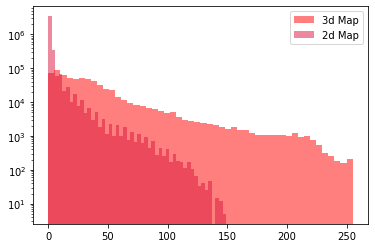

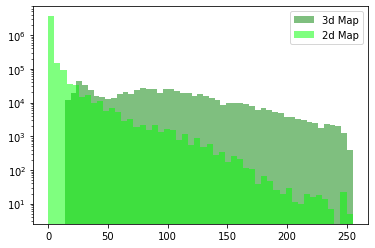

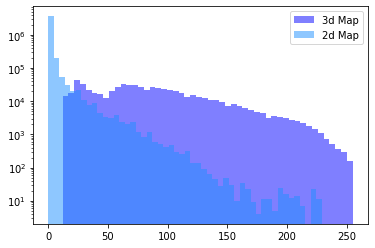

In [54]:
#Visually compare values by looking at their histograms
plt.hist(R_3dorion.flatten(), bins=50, color='red', alpha=0.5, label='3d Map')
plt.hist(R_orion.flatten(), bins=50, color='crimson', alpha=0.5, label='2d Map')
plt.yscale('log')
plt.legend(loc='upper right')
plt.show()

plt.hist(G_3dorion.flatten(), bins=50, color='green', alpha=0.5, label='3d Map')
plt.hist(G_orion.flatten(), bins=50, color='lime', alpha=0.5, label='2d Map')
plt.yscale('log')
plt.legend(loc='upper right')
plt.show()

plt.hist(B_3dorion.flatten(), bins=50, color='blue', alpha=0.5, label='3d Map')
plt.hist(B_orion.flatten(), bins=50, color='dodgerblue', alpha=0.5, label='2d Map')
plt.yscale('log')
plt.legend(loc='upper right')
plt.show()

In [55]:
#Crop Orion to make it easier to compare 
R_orion_cropped, G_orion_cropped, B_orion_cropped, orion_image_crop = vf.get_region_image(R, G, B, d_orionB, l_orionB, b_orionB, 1100, 600, scale=True)
orion_image_crop.save(orion_path + "/orion_rgb_scaled_cropped.png")

In [56]:
#Get RGB of a region of interest to make it easier to compare the values

R_orion_roi, G_orion_roi, B_orion_roi = calc.get_rgb_roi(R_orion_cropped, G_orion_cropped, B_orion_cropped, 150, 450, 350, 130)
R_orion_roi_3d, G_orion_roi_3d, B_orion_roi_3d = calc.get_rgb_roi(R_3dorion, G_3dorion, B_3dorion, 20, 420, 400, 150)

In [57]:
#Create new images of the roi
RGB_orion_roi = vf.create_image(R_orion_roi, G_orion_roi, B_orion_roi)
RGB_orion_roi.save(orion_path + "/orion_rgb_roi.png")

RGB_orion_roi_3d = vf.create_image(R_orion_roi_3d, G_orion_roi_3d, B_orion_roi_3d)
RGB_orion_roi_3d.save(orion_path + "/orion_rgb_roi_3d.png")

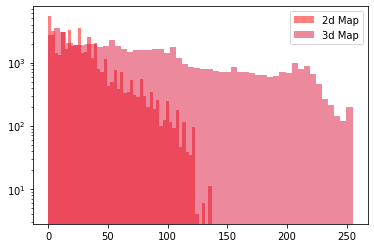

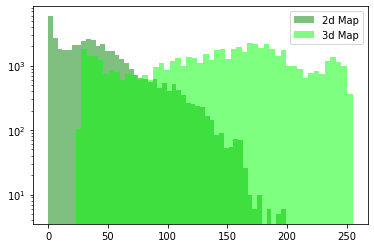

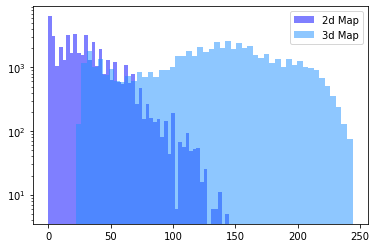

In [58]:
#Look at histograms of roi
plt.hist(R_orion_roi.flatten(), bins=50, color='red', alpha=0.5, label='2d Map')
plt.hist(R_orion_roi_3d.flatten(), bins=50, color='crimson', alpha=0.5, label='3d Map')
plt.yscale('log')
plt.legend(loc='upper right')
plt.show()

plt.hist(G_orion_roi.flatten(), bins=50, color='green', alpha=0.5, label='2d Map')
plt.hist(G_orion_roi_3d.flatten(), bins=50, color='lime', alpha=0.5, label='3d Map')
plt.yscale('log')
plt.legend(loc='upper right')
plt.show()

plt.hist(B_orion_roi.flatten(), bins=50, color='blue', alpha=0.5, label='2d Map')
plt.hist(B_orion_roi_3d.flatten(), bins=50, color='dodgerblue', alpha=0.5, label='3d Map')
plt.yscale('log')
plt.legend(loc='upper right')
plt.show()

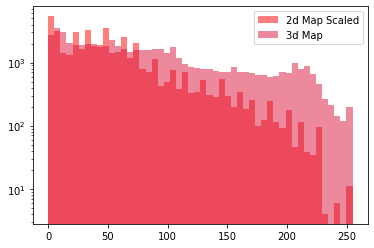

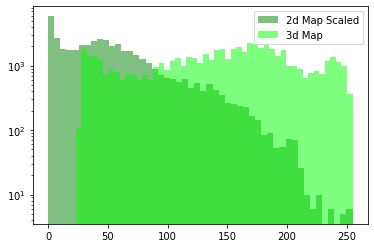

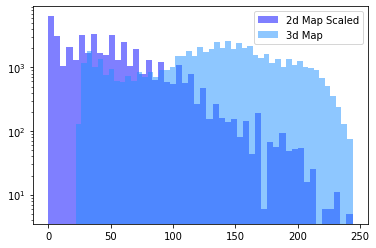

In [60]:
#Scale 2d map by maximum of 3d map in this roi to see difference 

max_2d_R = np.max(R_orion_roi)
max_3d_R = np.max(R_orion_roi_3d)
max_2d_G = np.max(G_orion_roi)
max_3d_G = np.max(G_orion_roi_3d)
max_2d_B = np.max(B_orion_roi)
max_3d_B = np.max(B_orion_roi_3d)


R_orion_roi_scaled = R_orion_roi * (max_3d_R/ max_2d_R)
G_orion_roi_scaled = G_orion_roi * (max_3d_G/ max_2d_G)
B_orion_roi_scaled = B_orion_roi * (max_3d_B/ max_2d_B)

plt.hist(R_orion_roi_scaled.flatten(), bins=50, color='red', alpha=0.5, label='2d Map Scaled')
plt.hist(R_orion_roi_3d.flatten(), bins=50, color='crimson', alpha=0.5, label='3d Map')
plt.yscale('log')
plt.legend(loc='upper right')
plt.show()

plt.hist(G_orion_roi_scaled.flatten(), bins=50, color='green', alpha=0.5, label='2d Map Scaled')
plt.hist(G_orion_roi_3d.flatten(), bins=50, color='lime', alpha=0.5, label='3d Map')
plt.yscale('log')
plt.legend(loc='upper right')
plt.show()

plt.hist(B_orion_roi_scaled.flatten(), bins=50, color='blue', alpha=0.5, label='2d Map Scaled')
plt.hist(B_orion_roi_3d.flatten(), bins=50, color='dodgerblue', alpha=0.5, label='3d Map')
plt.yscale('log')
plt.legend(loc='upper right')
plt.show()

RGB_orion_roi_scaled = vf.create_image(R_orion_roi_scaled, G_orion_roi_scaled, B_orion_roi_scaled)
RGB_orion_roi_scaled.save(orion_path + "/orion_rgb_roi_scaled.png")


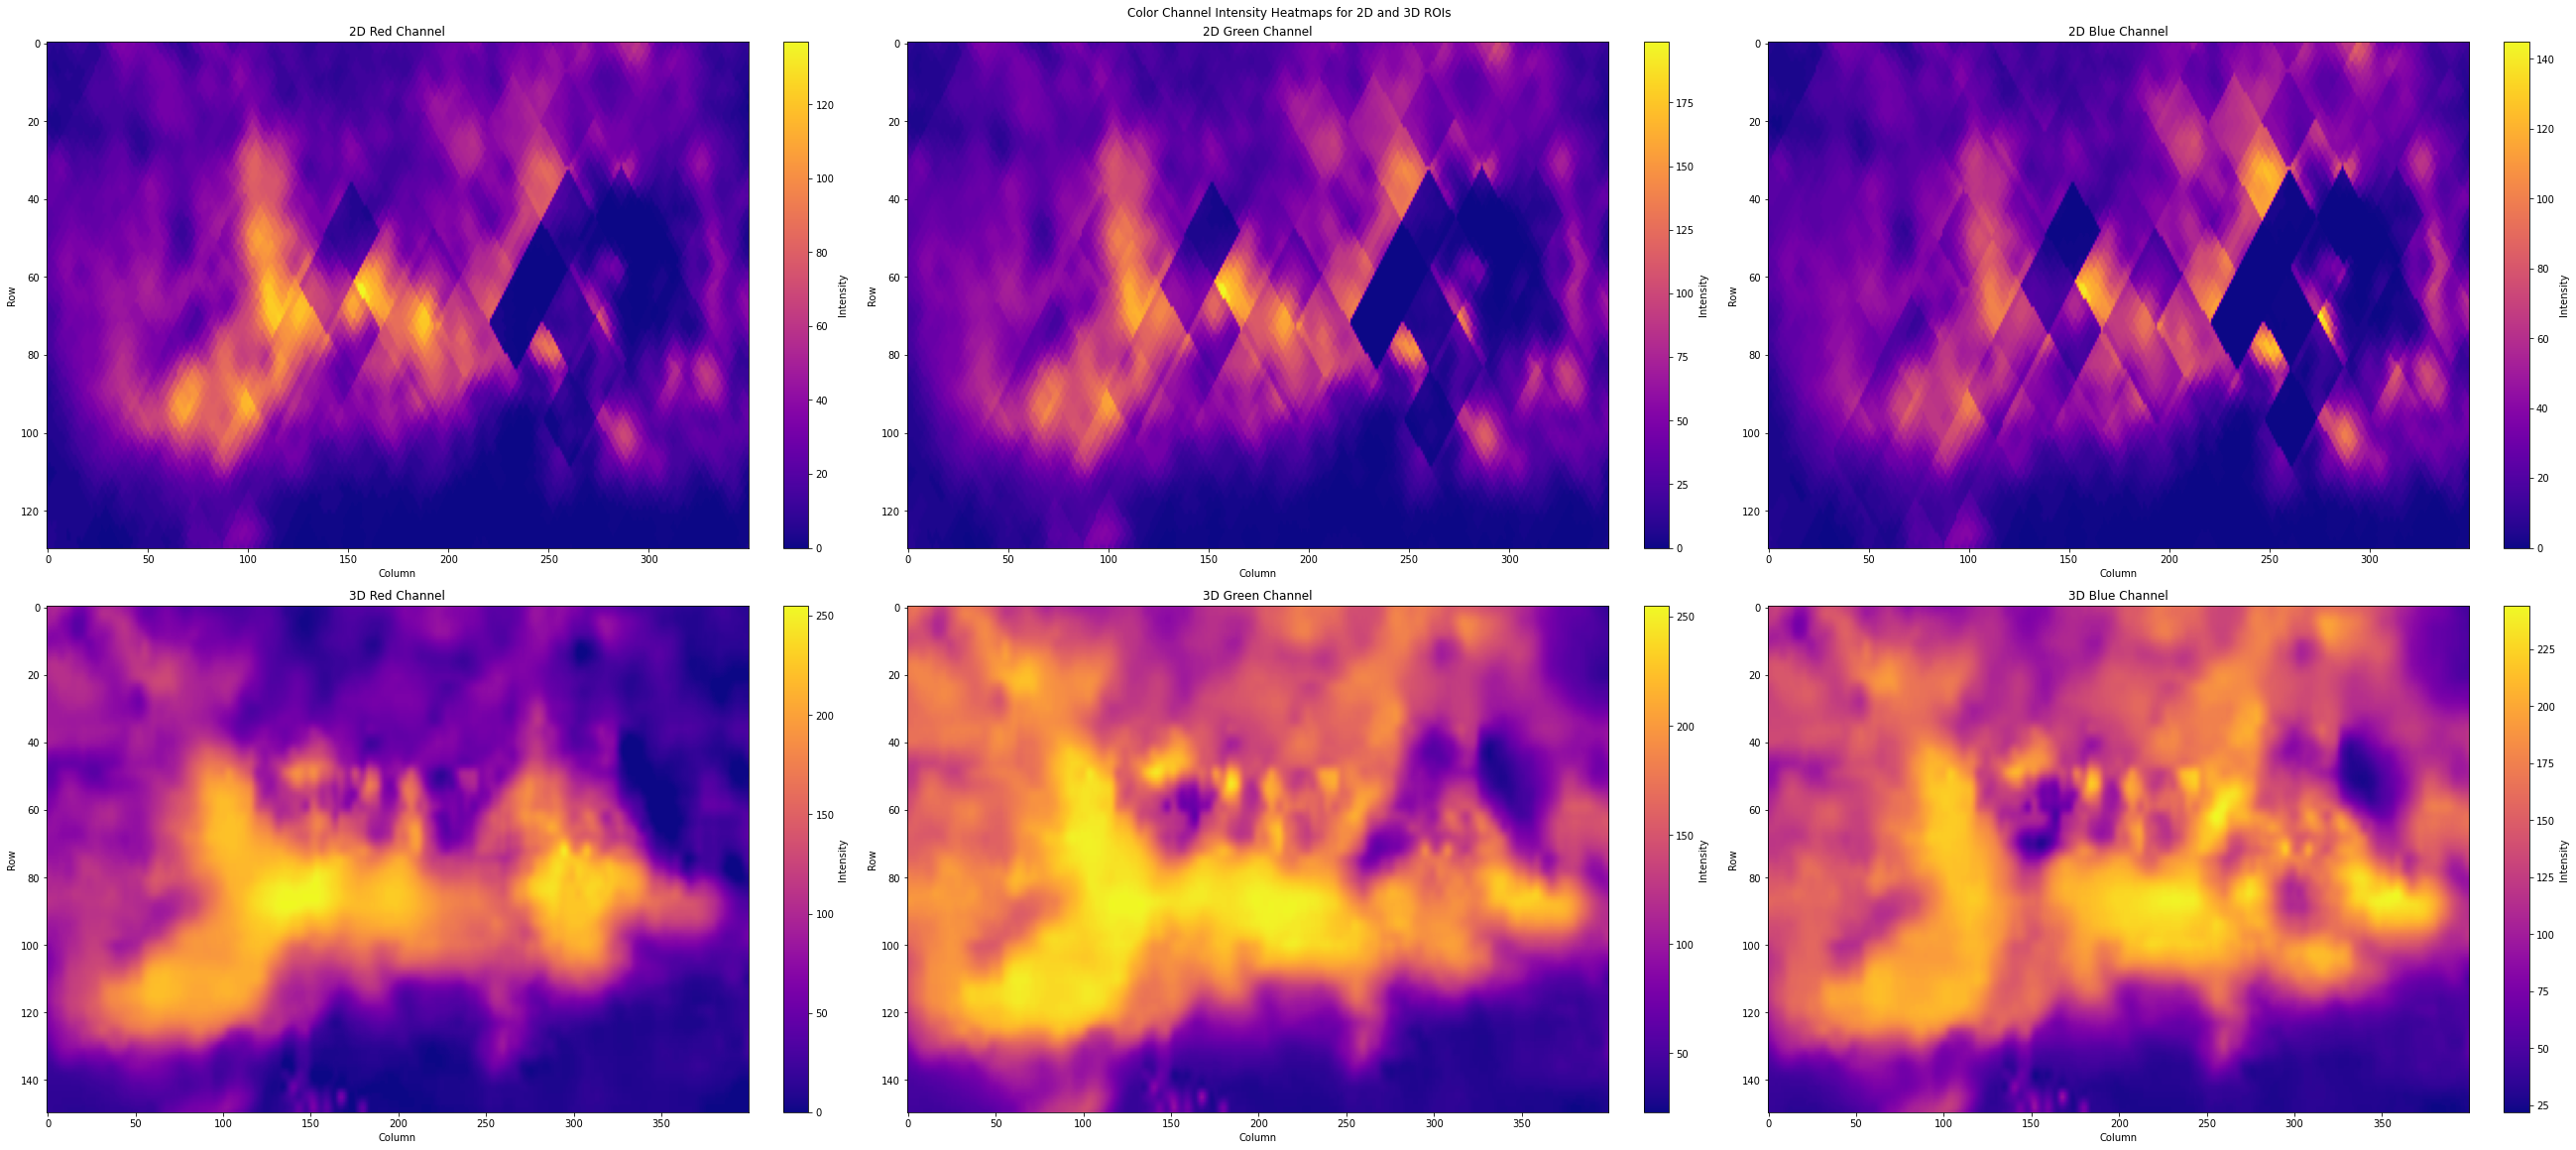

In [61]:
#Create a color map to see differences between 2d and 3d maps
cmap = "plasma"

# Create a figure with subplots
fig, axes = plt.subplots(2, 3, figsize=(36, 16), constrained_layout=True)

# Heatmaps for 2D ROIs
ax = axes[0, 0]
im = ax.imshow(R_orion_roi, cmap=cmap, aspect='auto')
ax.set_title('2D Red Channel')
ax.set_xlabel('Column')
ax.set_ylabel('Row')
fig.colorbar(im, ax=ax, orientation='vertical', label='Intensity')

ax = axes[0, 1]
im = ax.imshow(G_orion_roi, cmap=cmap, aspect='auto')
ax.set_title('2D Green Channel')
ax.set_xlabel('Column')
ax.set_ylabel('Row')
fig.colorbar(im, ax=ax, orientation='vertical', label='Intensity')

ax = axes[0, 2]
im = ax.imshow(B_orion_roi, cmap=cmap, aspect='auto')
ax.set_title('2D Blue Channel')
ax.set_xlabel('Column')
ax.set_ylabel('Row')
fig.colorbar(im, ax=ax, orientation='vertical', label='Intensity')

# Heatmaps for 3D ROIs
ax = axes[1, 0]
im = ax.imshow(R_orion_roi_3d, cmap=cmap, aspect='auto')
ax.set_title('3D Red Channel')
ax.set_xlabel('Column')
ax.set_ylabel('Row')
fig.colorbar(im, ax=ax, orientation='vertical', label='Intensity')

ax = axes[1, 1]
im = ax.imshow(G_orion_roi_3d, cmap=cmap, aspect='auto')
ax.set_title('3D Green Channel')
ax.set_xlabel('Column')
ax.set_ylabel('Row')
fig.colorbar(im, ax=ax, orientation='vertical', label='Intensity')

ax = axes[1, 2]
im = ax.imshow(B_orion_roi_3d, cmap=cmap, aspect='auto')
ax.set_title('3D Blue Channel')
ax.set_xlabel('Column')
ax.set_ylabel('Row')
fig.colorbar(im, ax=ax, orientation='vertical', label='Intensity')

plt.suptitle('Color Channel Intensity Heatmaps for 2D and 3D ROIs')
plt.show()

### Look at interactive plots

Analyze differences in pixels by using interactive plots. All commented out so as to not make file too big

In [4]:
#RGB images

#px.imshow(RGB_orion_roi_3d, title='3d Dustmap of Orion A & B LMCs', width=1100, height=600).show()
#px.imshow(RGB_orion_roi, title='My Dustmap of Orion A & B LMCs', width=1100, height=600).show()

In [1]:
#Just R of both
#px.imshow(R_orion_roi_3d, title='R Channel of 3d Dustmap of Orion A & B LMCs', width=1100, height=600).show()
#px.imshow(R_orion_roi, title='R Channel of My Dustmap of Orion A & B LMCs', width=1100, height=600).show()

In [2]:
#Just G of both
#px.imshow(G_orion_roi_3d, title='G Channel of 3d Dustmap of Orion A & B LMCs', width=1100, height=600).show()
#px.imshow(G_orion_roi, title='G Channel of My Dustmap of Orion A & B LMCs', width=1100, height=600).show()


In [3]:
#Just B of both
#px.imshow(B_orion_roi_3d, title='B Channel of 3d Dustmap of Orion A & B LMCs', width=1100, height=600).show()
#px.imshow(B_orion_roi, title='B Channel of My Dustmap of Orion A & B LMCs', width=1100, height=600).show()
